In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/PROJECT - NLP/semantic-segmentation/data/text/files

/content/drive/My Drive/PROJECT - NLP/semantic-segmentation/data/text/files


In [0]:
import os
import io
import pandas as pd

In [0]:
df = pd.read_csv('file2.csv')
df = df[df['isLong'] == False]

In [0]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 9.0MB/s 
     |████████████████████████████████| 3.7MB 63.6MB/s 
     |████████████████████████████████| 1.0MB 54.7MB/s 
     |████████████████████████████████| 890kB 51.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=7214c7fa21e5227d8eb85c0580f2babe3fce4d1c2f4fbc5aec6919ac0f0030b5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
from sklearn.model_selection import train_test_split
sentences,sentences1,labels,labels1 = train_test_split(df.Sentence.values,df.Label.values,test_size=0.1)

In [0]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 220,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  The self-inculpatory statements of Appellant and that of Prabhjot Singh were said to have been taken off the file
Token IDs: tensor([  101,  1996,  2969,  1011,  4297,  5313,  4502,  7062,  8635,  1997,
        10439, 24178,  1998,  2008,  1997, 10975,  7875,  2232,  5558,  2102,
         5960,  2020,  2056,  2000,  2031,  2042,  2579,  2125,  1996,  5371,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [0]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Create a 90-10 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,724 training samples
1,681 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 7, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of    211.    Elapsed: 0:00:44.
  Batch    80  of    211.    Elapsed: 0:01:30.
  Batch   120  of    211.    Elapsed: 0:02:17.
  Batch   160  of    211.    Elapsed: 0:03:04.
  Batch   200  of    211.    Elapsed: 0:03:51.

  Average training loss: 1.29
  Training epcoh took: 0:04:03

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.15
  Validation took: 0:00:22

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    211.    Elapsed: 0:00:47.
  Batch    80  of    211.    Elapsed: 0:01:34.
  Batch   120  of    211.    Elapsed: 0:02:21.
  Batch   160  of    211.    Elapsed: 0:03:08.
  Batch   200  of    211.    Elapsed: 0:03:54.

  Average training loss: 0.92
  Training epcoh took: 0:04:06

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.14
  Validation took: 0:00:22

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    211.    Elapsed: 0:00:47.
  Batch    80  of    211.    Elapsed: 0:01:34.
  Batch   120  of    211.    Elapsed: 0:02

In [0]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.29,1.15,0.59,0:04:03,0:00:22
2,0.92,1.14,0.62,0:04:06,0:00:22
3,0.61,1.26,0.61,0:04:06,0:00:22
4,0.34,1.42,0.60,0:04:06,0:00:22
5,0.19,1.65,0.62,0:04:06,0:00:22
6,0.12,1.79,0.62,0:04:06,0:00:22
7,0.07,2.01,0.63,0:04:06,0:00:22
8,0.05,2.12,0.63,0:04:06,0:00:22
9,0.03,2.23,0.63,0:04:05,0:00:22


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


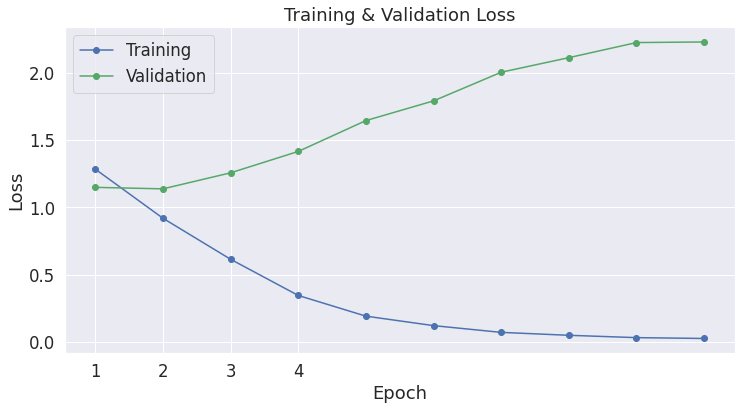

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [0]:
input_ids = []
attention_masks = []

for sent in sentences1:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 220,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels1)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  The self-inculpatory statements of Appellant and that of Prabhjot Singh were said to have been taken off the file
Token IDs: tensor([  101,  1996,  9385,  2552,  1010,  3890,  1006,  2005,  2460,  1010,
         1000,  1996,  2552,  1000,  1007,  2001, 11955,  2000, 27950,  1998,
        24939,  1996,  2375,  8800,  2000,  9385,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [0]:
import numpy as np

preds_labels = []
l = len(input_ids)
for i in range(l):
  t = model(input_ids[i].unsqueeze(0).cuda(), attention_mask=attention_masks[i].unsqueeze(0).cuda(),labels=labels[i].unsqueeze(0).cuda())[1]
  preds_labels.append(np.argmax(t.detach().cpu().numpy()))

In [0]:
from sklearn.metrics import classification_report
dic = classification_report(labels,preds_labels, labels=[0,1,2,3,4,5,6], target_names=['Argument', 'Facts', 'Precedent', 'Ratio of the decision','Ruling by Lower Court', 'Ruling by Present Court', 'Statute'], digits=2, output_dict=True, zero_division='warn')
print(dic)
df_report = pd.DataFrame(data = dic)

{'Argument': {'precision': 0.6521739130434783, 'recall': 0.5, 'f1-score': 0.5660377358490566, 'support': 90}, 'Facts': {'precision': 0.6962616822429907, 'recall': 0.7028301886792453, 'f1-score': 0.6995305164319249, 'support': 212}, 'Precedent': {'precision': 0.6410256410256411, 'recall': 0.5033557046979866, 'f1-score': 0.5639097744360904, 'support': 149}, 'Ratio of the decision': {'precision': 0.6532066508313539, 'recall': 0.7352941176470589, 'f1-score': 0.6918238993710691, 'support': 374}, 'Ruling by Lower Court': {'precision': 0.391304347826087, 'recall': 0.391304347826087, 'f1-score': 0.391304347826087, 'support': 23}, 'Ruling by Present Court': {'precision': 0.72, 'recall': 0.6206896551724138, 'f1-score': 0.6666666666666666, 'support': 29}, 'Statute': {'precision': 0.6307692307692307, 'recall': 0.7192982456140351, 'f1-score': 0.6721311475409837, 'support': 57}, 'accuracy': 0.6552462526766595, 'macro avg': {'precision': 0.6263916379626829, 'recall': 0.5961103228052609, 'f1-score': 0

In [0]:
df_report

,Argument,Facts,Precedent,Ratio of the decision,Ruling by Lower Court,Ruling by Present Court,Statute,accuracy,macro avg,weighted avg
precision,0.65,0.7,0.64,0.65,0.39,0.72,0.63,0.66,0.63,0.66
recall,0.50,0.7,0.50,0.74,0.39,0.62,0.72,0.66,0.60,0.66
f1-score,0.57,0.7,0.56,0.69,0.39,0.67,0.67,0.66,0.61,0.65
support,90.00,212.0,149.00,374.00,23.00,29.00,57.00,0.66,934.00,934.00
